# Exploring the FuseTS Toolbox: Fusing Optical and SAR Data for Phenology Analysis

Welcome to the showcase of the FuseTS library, an integral part of the AI4FOOD project, presented at the FOSS4G conference. In this Jupyter notebook, we will demonstrate how the FuseTS library enables users to effectively fuse optical and SAR data, harnessing the power of fused data sets combined time series analytics for extracting valuable phenology information.

Throughout this notebook, we will compare the results obtained from a raw dataset with those obtained from the fused dataset, illustrating the significant improvements in extracting phenology information. By integrating optical data, which provides detailed spectral information, with SAR data, which excels in all-weather and day-night imaging, the FuseTS library empowers users to unlock deeper insights into vegetation dynamics and crop monitoring.

**Prerequisites**

- You can start from a clean **Python 3.8** environment. During this notebook, we'll be installing the necessary dependencies.
- In this notebook, we utilize openEO to retrieve time series data. To leverage the full range of openEO features, you can create a free trial account on the [openEO Platform](https://docs.openeo.cloud/join/free_trial.html) and receive 1000 free credits, enabling you to execute the functionalities showcased in this notebook.


Lets start with importing the different libraries that we need within this notebook.


## Setting up the environment

First of all we need to make sure that all our dependencies are correctly installed.


In [ ]:
# Do not execute this cell when using the Docker image
# !pip install numpy==1.23.5 cython
# !pip install ../../.
# !pip install -r requirements.txt

In [3]:
pip install openeo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.0 MB/s  0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.10.1
    Uninstalling xarray-2025.10.1:
      Successfully uninstalled xarray-2025.10.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [openeo]2m3/4 [openeo]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fusets 2.0.2a1 requires cython, which is not installed.
fusets 2.0.2a1 requires GPy>=1.10.0, which is not installed.
fusets 2.0.2a1 requires lcmap-pyccd==2021.7.19, which is not installed.
fusets 2.0.2a1 requires vam.whittaker==2.0.6, which is not installed.
fusets 2.0.2a1 requires numpy==1.23.5, but you have numpy 2.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import itertools
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import openeo
import pandas as pd
import xarray
from ipyleaflet import GeoJSON, Map, basemaps
from openeo.processes import eq
from openeo.rest.conversions import timeseries_json_to_pandas

from fusets.analytics import phenology
from fusets.mogpr import mogpr_1D
from fusets.whittaker import whittaker

#warnings.filterwarnings("ignore")

# PART 1: Downloading the raw S2 NDVI time series

We start by downloading the raw S2 NDVI data that we need for our analysis.

Retrieving time series data can be done through various methods, and one such method is using openEO. [OpenEO](https://openeo.org/) is an API that provides access to a variety of Earth Observation (EO) data and processing services in a standardized and easy-to-use way. By leveraging the power of openEO, we can easily retrieve the time series data for the meadow and use it to analyze the patterns and trends.

More information on the usage of openEO's Python client can be found on [GitHub](https://github.com/Open-EO/openeo-python-client).

The first step is to connect to an openEO compatible backend.


In [3]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Visit https://aai.egi.eu/device?user_code=ACSJ-TIBX 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


Check out also the free 30-day trial setup for openEO [here](https://docs.openeo.cloud/join/free_trial.html)!

Next we define the area of interest, in this case an extent, for which we would like to fetch time series data.


In [4]:
year = 2019
spat_ext = {
    "coordinates": [
        [
            [-4.875091217039325, 41.77290587433312],
            [-4.872773788450457, 41.77290587433312],
            [-4.872773788450457, 41.77450614847532],
            [-4.875091217039325, 41.77450614847532],
            [-4.875091217039325, 41.77290587433312],
        ]
    ],
    "type": "Polygon",
}
temp_ext = [f"{year}-01-01", f"{year}-12-30"]

Plot the area to see what we're working with.


In [5]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 16

m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m

Map(center=[41.773545983990005, -4.874164245603778], controls=(ZoomControl(options=['position', 'zoom_in_text'…

We will be working with with the rapeseed from 2019, located in the Nothern Spain.

We will create an openEO process to calculate the NDVI time series for our area of interest. First we begin by using the `SENTINEL2_L2A_SENTINELHUB` collection, and apply a `Sen2Cor` cloud masking algorithm to remove any interfering clouds before calculating the NDVI values.


In [6]:
scl = connection.load_collection(
    "SENTINEL2_L2A_SENTINELHUB",
    spatial_extent=spat_ext,
    temporal_extent=temp_ext,
    bands=["SCL"],
)
cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)
s2 = connection.load_collection(
    "SENTINEL2_L2A_SENTINELHUB",
    spatial_extent=spat_ext,
    temporal_extent=temp_ext,
    bands=["B04", "B08", "CLM"],
)
s2 = s2.mask(cloud_mask)
s2 = s2.mask_polygon(spat_ext)
ndvi_cube = s2.ndvi(red="B04", nir="B08", target_band="NDVI")

If more information about a particular process is needed (such as the cloud masking), you can find out more the following way:


In [7]:
connection.describe_process("to_scl_dilation_mask")

{'categories': ['cubes', 'ard'],
 'description': "Create a mask for clouds by dilating Sen2Cor sceneclassification. Requires a datacube with only Sentinel-2 L2A 'SCL' band as input. This dilation algorithm removes pixels in the neighbourhood of clouds in a fairly aggressive manner, to avoid any type of contamination. Nevertheless, some outliers can sometimes still remain.",
 'experimental': True,
 'id': 'to_scl_dilation_mask',
 'parameters': [{'description': 'The source data cube containing only the Sentinel-2 SCL band.',
   'name': 'data',
   'schema': {'subtype': 'datacube', 'type': 'object'}},
  {'default': 0,
   'description': '',
   'name': 'erosion_kernel_size',
   'optional': True,
   'schema': {'type': 'number'}},
  {'default': [2, 4, 5, 6, 7],
   'description': '',
   'name': 'mask1_values',
   'optional': True,
   'schema': {'items': {'type': 'number'}, 'type': 'array'}},
  {'default': [3, 8, 9, 10, 11],
   'description': '',
   'name': 'mask2_values',
   'optional': True,
   'schema': {'items': {'type': 'number'}, 'type': 'array'}},
  {'default': 17,
   'description': 'Size of the first convolution kernel.',
   'name': 'kernel1_size',
   'optional': True,
   'schema': {'type': 'number'}},
  {'default': 201,
   'description': 'Size of the second convolution kernel.',
   'name': 'kernel2_size',
   'optional': True,
   'schema': {'type': 'number'}}],
 'returns': {'description': 'SCL dilation mask.',
  'schema': {'subtype': 'datacube', 'type': 'object'}},
 'summary': 'Create a mask for clouds by dilating Sen2Cor sceneclassification'}

Now that we have calculated the NDVI time series for our area of interest, we can request openEO to download the result to our local storage. This will allow us to access the file and use it for further analysis in this notebook.


In [8]:
ndvi_output_file = "./raw_s2_ndvi_field.nc"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# ndvi_job = ndvi_cube.execute_batch(
#     ndvi_output_file, title=f"FOSS4G - FUSETS - Phenology - Raw NDVI", out_format="netCDF"
# )

# load the dataset and check it's structure
raw_ndvi_ds = xarray.load_dataset(ndvi_output_file)
raw_ndvi_ds

<xarray.Dataset> Size: 198kB
Dimensions:  (t: 31, x: 21, y: 19)
Coordinates:
  * t        (t) datetime64[ns] 248B 2019-01-27 2019-02-11 ... 2019-12-28
  * x        (x) float64 168B 3.442e+05 3.442e+05 ... 3.443e+05 3.444e+05
  * y        (y) float64 152B 4.626e+06 4.626e+06 ... 4.626e+06 4.626e+06
Data variables:
    crs      |S1 1B b''
    B04      (t, y, x) float32 49kB nan 1.212e+03 1.226e+03 ... nan nan nan
    B08      (t, y, x) float32 49kB nan 1.934e+03 1.964e+03 ... nan nan nan
    SCL      (t, y, x) float32 49kB nan 5.0 5.0 5.0 5.0 ... nan nan nan nan nan
    NDVI     (t, y, x) float32 49kB nan 0.2295 0.2313 0.2318 ... nan nan nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.11.0a1
    description:  
    title:

Plot the raw NDVI time series, averaged across the parcel


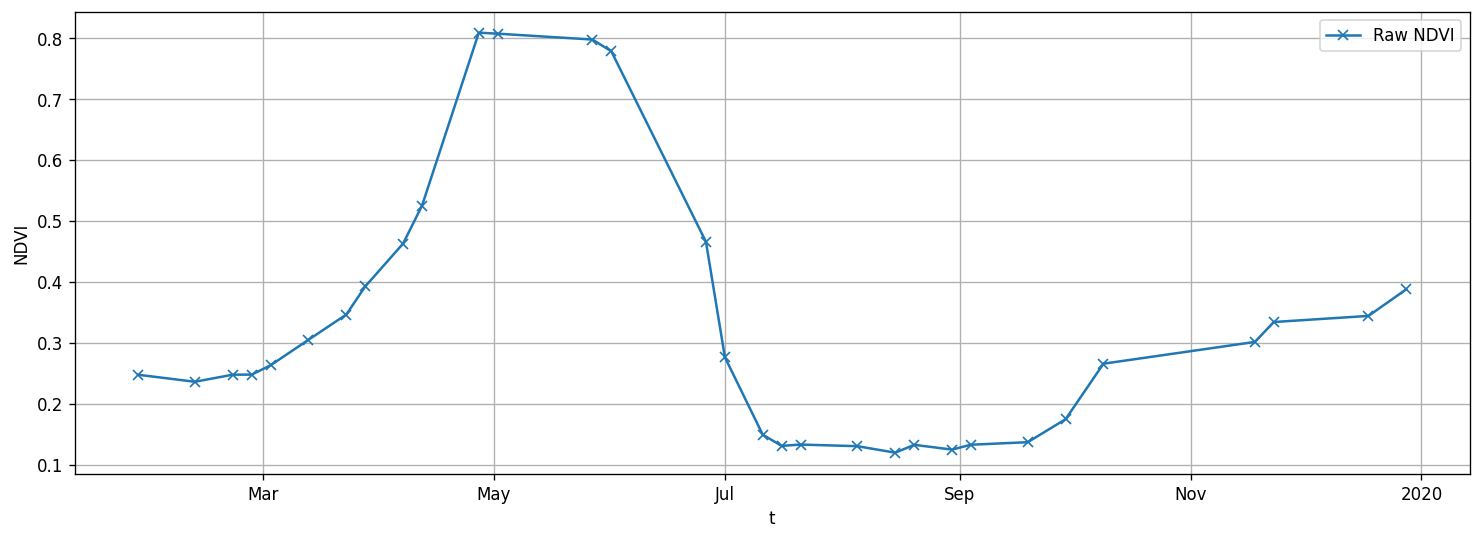

In [9]:
raw_ndvi = raw_ndvi_ds.NDVI.rename({"t": "time"})

fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI")
ax.legend()
ax.grid()

## PART 2: Creating a smoothed dataset using Whittaker

Whittaker smoother represents a computationally efficient reconstruction method for smoothing and gap-filling of time series which is why it is used here. (Eilers, P. H., 2003: A perfect smoother. Analytical chemistry, 75 (14), 3631–3636.)

The Whittaker algorithm is available in the FuseTS toolbox as a **user-defined-function** (**UDF**) and can be used to create a smoothed time series. It employs a discrete penalized least squares algorithm that fits a smooth series, denoted as z, to the original data series, denoted as y.

UDFs are convenient ways to apply your own custom algorithms on openEO datacubes. Read more about UDFs [here](https://openeo.org/documentation/1.0/udfs.html)


In [10]:
# Make a prediction every 5 days
# to use the same dates as in the raw time series, just set the `prediction_period` to `None`
smoothed = whittaker(raw_ndvi, prediction_period="P5D", smoothing_lambda=10)

ModuleNotFoundError: No module named 'vam'

Plot the original raw NDVI as well as the smoothed NDVI


In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI", color="C0")
smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Smoothed NDVI", color="C1")
ax.legend()
ax.grid()

## PART 3: Creating fused time series with MOGPR

In this section, we will begin the process of creating our first fused dataset using the MOGPR (Multi-Output Gaussian Process Regression) technique. The process uses probabilistic theory to describe the time series using families of functions in a non-parametric way, and extracts the correlation between different inputs in order to merge the information together. The probabilistic nature of the process also provides uncertainty levels.

The fusion process will involve combining Sentinel-1 (S1) RVI and Sentinel-2 (S2) NDVI data. To accomplish this, we will leverage the powerful capabilities of the FuseTS library.

### Calculating the S1 RVI and S2 NVDI timeseries

As the first step, we will use openEO to download the S1 RVI and S2 NDVI time series data required as input for the MOGPR service. This process ensures that we have the necessary data available for further fusion using the MOGPR algorithm.


In [12]:
# helper function for calculating RVI
def calculate_rvi(dc):
    VH = dc.band("VH")
    VV = dc.band("VV")
    return (VH + VH) / (VV + VH)


# helper function for downloading S1 data
def get_s1_data(ascending=True):
    s1_data = connection.load_collection(
        "SENTINEL1_GRD",
        spatial_extent=spat_ext,
        temporal_extent=temp_ext,
        bands=["VH", "VV"],
        properties={
            "sat:orbit_state": lambda x: eq(x, "ASCENDING" if ascending else "DESCENDING"),
            "resolution": lambda x: eq(x, "HIGH"),
            "sar:instrument_mode": lambda x: eq(x, "IW"),
        },
    )
    return calculate_rvi(s1_data)


# RVI ASCENDING
rvi_asc_cube = get_s1_data(ascending=True)
rvi_des_cube = get_s1_data(ascending=False)

# NDVI
ndvi_cube = s2.ndvi(red="B04", nir="B08")

Next, we will utilize openEO to calculate the time series for our Area of Interest (AOI) for each of the input datasets for MOGPR.


In [13]:
output_file = "mogpr_input.csv"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# cubes_dfs = []
# for cube in [ndvi_cube, rvi_asc_cube, rvi_des_cube]:
#     timeseries = cube.polygonal_mean_timeseries(spat_ext).execute()
#     timeseries_df = timeseries_json_to_pandas(timeseries)
#     timeseries_df.index = pd.to_datetime(timeseries_df.index)
#     cubes_dfs.append(timeseries_df)

# # Join signals
# mogpr_df = pd.concat(cubes_dfs, axis=1)
# mogpr_df = mogpr_df.rename(columns={0: 'NDVI', 1: 'RVI_DESC', 2: 'RVI_ASC'})
# mogpr_df.to_csv(output_file)

In [14]:
# Show the downloaded tabular data, aggregated over parcel and over timestamp
mogpr_df = pd.read_csv(output_file)
mogpr_df["date"] = pd.to_datetime(mogpr_df["date"])
mogpr_df.set_index("date", inplace=True)
mogpr_df.head(10)

,NDVI,RVI_DESC,RVI_ASC
date,,,
2019-01-02 00:00:00+00:00,NaN,NaN,NaN
2019-01-05 00:00:00+00:00,NaN,0.029469,0.130933
2019-01-06 00:00:00+00:00,NaN,NaN,0.134842
2019-01-07 00:00:00+00:00,NaN,NaN,NaN
2019-01-11 00:00:00+00:00,NaN,0.036907,0.124199
2019-01-12 00:00:00+00:00,NaN,NaN,0.164894
2019-01-17 00:00:00+00:00,NaN,0.020850,0.133011
2019-01-18 00:00:00+00:00,NaN,NaN,0.128349
2019-01-23 00:00:00+00:00,NaN,0.068632,0.141661


(0.0, 1.0)

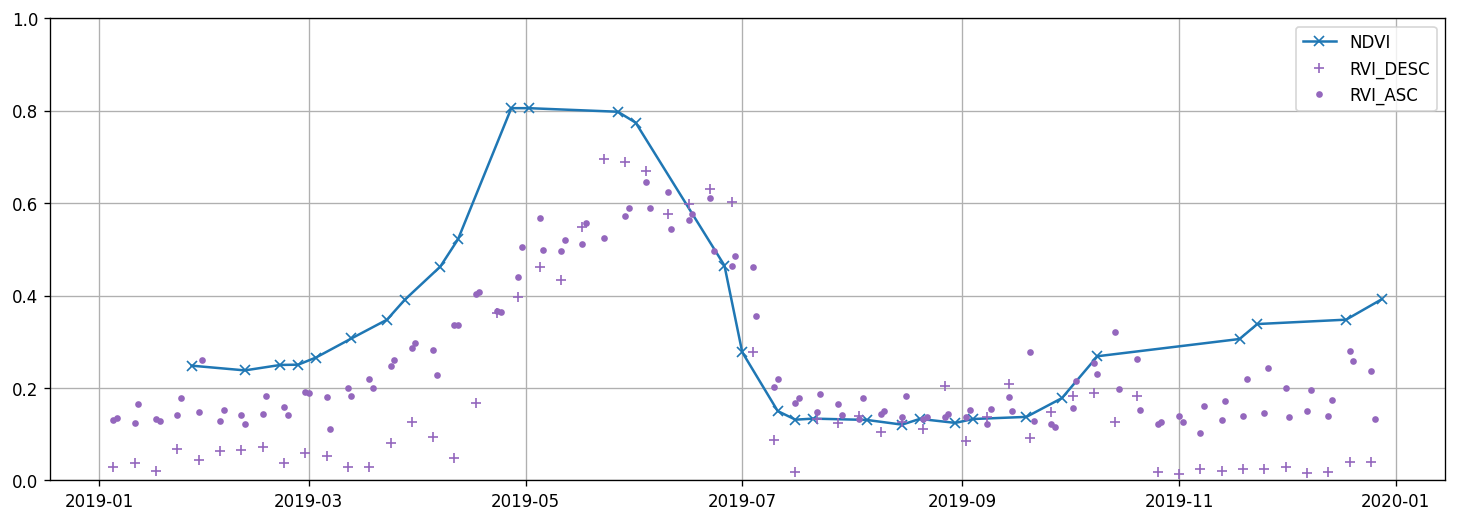

In [15]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

style_dict = {
    "NDVI": dict(marker="x", color="C0"),
    "RVI_DESC": dict(marker="+", color="C4", lw=0),
    "RVI_ASC": dict(marker=".", color="C4", lw=0),
}

for col in mogpr_df.columns:
    ax.plot(mogpr_df[col].dropna(), label=col, **style_dict[col])

ax.legend()
ax.grid(True)
ax.set_ylim([0, 1])

### Executing MOGPR

In order to process the time series data, some additional preprocessing is required to execute the MOGPR algorithm. This includes extracting the different time steps that are available in the input data.

The step here may seem unnecessary, but it's merely transforming the data into a format which is expected by the `GPy` library containing the MOGPR logic.


In [16]:
# Use only 2 signals
signals = ["RVI_DESC", "NDVI"]

doy_step = 5
doy, data = [], []

# create integer-nature time vectors for all inputs
for signal in signals:
    doy.append(mogpr_df.index.day_of_year.to_numpy())
    data.append(mogpr_df[signal].to_numpy())

doy_min = np.min(list(itertools.chain(*doy)))
doy_max = np.max(list(itertools.chain(*doy)))
output_doy = np.arange(doy_min, doy_max, doy_step)
output_time = pd.to_datetime(output_doy, unit="D", origin=datetime(2019, 1, 1))

The logic behing the MOGPR algorithm is quite complex and we will not go into details. A good place to start learning more is [this tutorial](https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb).

In principle, imagine the process doing the following:

1. the model finds non-parametric descriptions of the time-series using a family of functions
2. the model extracts the level of correlation between the inputs
3. the model constructs the non-parametric outputwith optimal hyper-parameters for describing the functions and taking the correlations into account


In [17]:
# run the MOGPR fit
master_ind = 1
out_mean, out_std, out_qflag, out_model = mogpr_1D(
    data_in=data, time_in=doy, master_ind=master_ind, output_timevec=output_doy, nt=1
)

ModuleNotFoundError: No module named 'GPy'

Let's convert the output of the service to a pandas dataframe and plot the results.


In [ ]:
# construct a pandas dataframe from the output
mogpr = pd.DataFrame({"NDVI": out_mean[master_ind], "NDVI_std": out_std[master_ind]})
mogpr["time"] = output_time
mogpr.set_index("time", inplace=True)

mogpr.head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

ax.plot(mogpr_df["NDVI"].dropna(), "x-", color="C0", label="Raw NDVI")
smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Smoothed NDVI", color="C1", alpha=0.3)

ax.plot(mogpr["NDVI"], "x-", color="C2", label="Fused NDVI (MOGPR)")
ax.fill_between(
    x=mogpr.index,
    y1=mogpr["NDVI"] - mogpr["NDVI_std"],
    y2=mogpr["NDVI"] + mogpr["NDVI_std"],
    color="C2",
    alpha=0.25,
    label="Fused NDVI (MOGPR) st.dev.",
)

ax.set_ylim([0, 1])
ax.legend()

## PART 4: Creating the fused data set using CropSAR

In the following section, we will leverage the capabilities of the toolbox to generate a fused dataset using CropSAR. The CropSAR service is specifically designed to enhance crop monitoring and analysis by integrating Sentinel-2 optical observations with Sentinel-1 radar data. This fusion process empowers users to monitor agricultural fields regardless of weather conditions or daylight availability, making it an invaluable tool for comprehensive crop assessment.

To execute the CropSAR service and obtain the fused dataset, we will once again utilize openEO. By leveraging openEO, we can easily harness the power of CropSAR and efficiently download the fused dataset, enabling further analysis and extraction of valuable phenology information in the next part. The CropSAR service is exposed as a public openEO [user-defined process (UDP)](https://open-eo.github.io/openeo-python-client/udp.html#user-defined-processes), enabling easy re-use and integration into any existing workflow.


In [ ]:
service = "CropSAR_px"
namespace = "vito" # CropSAR at the moment only exists in the VITO namespace

In [ ]:
cropsar_cube = connection.datacube_from_process(
    service,
    namespace=namespace,
    geometry=spat_ext,
    startdate=temp_ext[0],
    enddate=temp_ext[1],
    version=2,
    model_path="tmp/model/cnn_transformer/",
    path_extras=["tmp/env/env/"],
)

In [ ]:
cropsar_output_file = "./cropsar_ndvi.nc"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# cropsar_job = cropsar_cube.execute_batch(
#     cropsar_output_file,
#     title="FOSS4G - FUSETS - Phenology - CropSAR",
#     out_format="netcdf",
#     job_options={
#         "executor-cores": "8",
#         "task-cpus": "8",
#         "executor-memoryOverhead": "2g",
#         "udf-dependency-archives": [
#             "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/20230504T175919_cnn_transformer.zip#tmp/model/cnn_transformer",
#             "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/env.tar.gz#tmp/env",
#         ],
#     },
# )

# load the dataset and check it's structure
cropsar_ds = xarray.load_dataset(cropsar_output_file)
cropsar_ds

In [ ]:
cropsar = cropsar_ds.NDVI.rename({"t": "time"}) / 255  # from uint8 to float32

fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI", color="C0")
smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Smoothed NDVI", color="C1", alpha=0.3)
mogpr["NDVI"].plot(ax=ax, marker="x", label="Fused NDVI (MOGPR)", color="C2", alpha=0.3)
cropsar.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="CropSAR fused NDVI", color="C3")
ax.legend()
ax.grid()

## PART 5: Phenology calculation

In this final step, we will utilize both the raw and CropSAR-based time series data to extract valuable phenology information. To accomplish this, we will employ the `phenology` service. By leveraging this service, we can extract a range of essential metrics, including the start, peak, and end of the growing season.

The calculation is based on the [phenolopy]() python package.

![phenolopy](https://github.com/lewistrotter/Phenolopy/raw/main/documentation/images/pheno_explain.png?raw=true)


In [ ]:
# run phenology on raw NDVI
raw_phenology = phenology(raw_ndvi)

# run phenology on Whittaker smoothed
whittaker_phenology = phenology(smoothed)

# run phenology on MOGPR
mogpr_phenology = phenology(mogpr.to_xarray().NDVI)

# run phenology on fused NDVI
cropsar_phenology = phenology(cropsar)

In [ ]:
# utility function to extract phenology metrics
def get_phenology_metric(phenology_data, metric):
    if "x" in phenology_data.dims:
        metric_data = phenology_data[metric].median(["x", "y"]).values.take(0)
    else:
        metric_data = phenology_data[metric].values.take(0)

    return datetime(year, 1, 1) + timedelta(days=metric_data if not np.isnan(metric_data) else 0)


for title, metric in zip(["Start of season", "Peak of season", "End of season"], ["sos", "pos", "eos"]):
    fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

    raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", color="C0", label="Raw Data")
    smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", color="C1", label="Smoothed Data (Whittaker)")
    mogpr["NDVI"].plot(ax=ax, marker="x", color="C2", label="Fused Data (MOGPR)")
    cropsar.median(dim=["x", "y"]).plot(ax=ax, marker="x", color="C3", label="Fused Data (CropSAR)")
    ax.legend()
    ax.grid()

    ax.axvline(get_phenology_metric(raw_phenology, f"{metric}_times"), color="C0")
    ax.axvline(get_phenology_metric(whittaker_phenology, f"{metric}_times"), color="C1")
    ax.axvline(get_phenology_metric(mogpr_phenology, f"{metric}_times"), color="C2")
    ax.axvline(get_phenology_metric(cropsar_phenology, f"{metric}_times"), color="C3")
    ax.set_title(title)

The basic phenology metrics (Start Of Season(SOS), Peak Of Season(POS), End Of Season(EOS)) are presented above.
In this case, SOS and EOS are calculated using one of the available methodologies, first of slope. This allows to characterize the seasonality of the crop.

With this last step, an integral workflow is demonstrated: from the raw data acquisition and fused time series generation to the retrieval of phenology metrics.
